# A3 - EDA - Understanding Correlations

#### Throughout the exercise, there are blanks you will need to fill in, these blanks are highlighted with three dashes `---` or an empty cell

One area we didn't look at during the workshop was correlations. When we go to build our machine learning model we'll be relying a lot on correlations between our training data and our targets so it's always useful to start taking a look at these early. Correlations are vital but can also cause problems during modeling (especially during inference) that we also need to account for.

### How Correlations help
1. Feature selection - understanding how features are correlated with our targets can help us reduce our feature space and build simpler models
2. Model selection - do we see strong linear correlations between features and targets? If so we can consider linear models, otherwise we might need to reply on nonlinear approaches such as trees or neural networks

### How Correlations can Hinder
1. Multicollinearity issues - if we have strong correlations (or identical) between features it can cause numerical errors during model training for certain model types
2. Inaccurate statistical inference - if we wish to report the effect size of our training features on our targets, correlations between features can cause the model to provide false assessments of effect sizes

Given the above it is useful to assess both:
- Correlations between features and targets
- Correlations within features

#### We'll be using the resistance gene presence/absence as our feature here

## Imports

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Load Required Data

Just run the below cell to get the data set up

In [4]:
def load_data():
    """
    Load the data needed for Workshop 3
    """
    gene_alignment_df = pd.read_csv('../data/train_genes.csv')
    amr_df = pd.read_csv('../data/amr_data.csv').drop(columns=['Unnamed: 0'])
    genome_summary_df = pd.read_csv('../data/e_coli_summary_data.csv').drop(columns=['Unnamed: 0'])

    # Subset IDS
    genome_summary_df = genome_summary_df[genome_summary_df.genome_id.isin(gene_alignment_df.genome_id.unique())]
    amr_df = amr_df[amr_df.genome_id.isin(gene_alignment_df.genome_id.unique())]
    
    return gene_alignment_df, amr_df, genome_summary_df

gene_alignment_df, amr_df, genome_summary_df = load_data()

# Rebuild our gene presence absence data from the exercise
gene_presence_absence = (
    gene_alignment_df
    [['genome_id', 'res_gene']]
    .assign(count = 1)
    .pivot_table('count', index='genome_id', columns="res_gene")
    .fillna(0)
) 

# Create our Target class again
resistant_to_ris = {
    'Susceptible':'S', 
    'Susceptible-dose dependent':'R', 
    'Intermediate':'R', 
    'Resistant':'R'
}
amr_df['target'] = amr_df.resistant_phenotype.apply(lambda x: resistant_to_ris.get(x))

## 1. Feature to Feature Correlations

Lets start by reviewing the correlations between our potential features: presence or absence of resistance genes.

#### Q1a. How many unique genes do we have?

Use `gene_alignment_df`

In [10]:
unique_genes = gene_alignment_df['res_gene'].unique()
print("N unique genes: ", len(unique_genes))

N unique genes:  1428


#### Q1b. How many unique presence/absence profiles do we have?

Use `gene_presence_absence`

Hint: pandas can remove duplicate rows, if we can get each gene as a row we can drop ones with identical profiles across the genes: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html, try transposing!

In [12]:
unique_profiles = gene_presence_absence.drop_duplicates()
n_unique_profiles = len(unique_profiles)

In [8]:
print("N unique presence/absence profiles: ", n_unique_profiles)

N unique presence/absence profiles:  563


You should see that there are far fewer unique profiles than there are genes - this means some genes are redundant (they appear/do not appear in exactly the same samples)

#### Q1c. Visualize the Correlations between Genes

Use `gene_presence_absence`

Lets see what this looks like visually - for this we can leverage pandas and matplotlib:
1. Calculate correlations using pandas
2. Use "matshow" to display the correlation matrix
3. Don't forget to label your plot

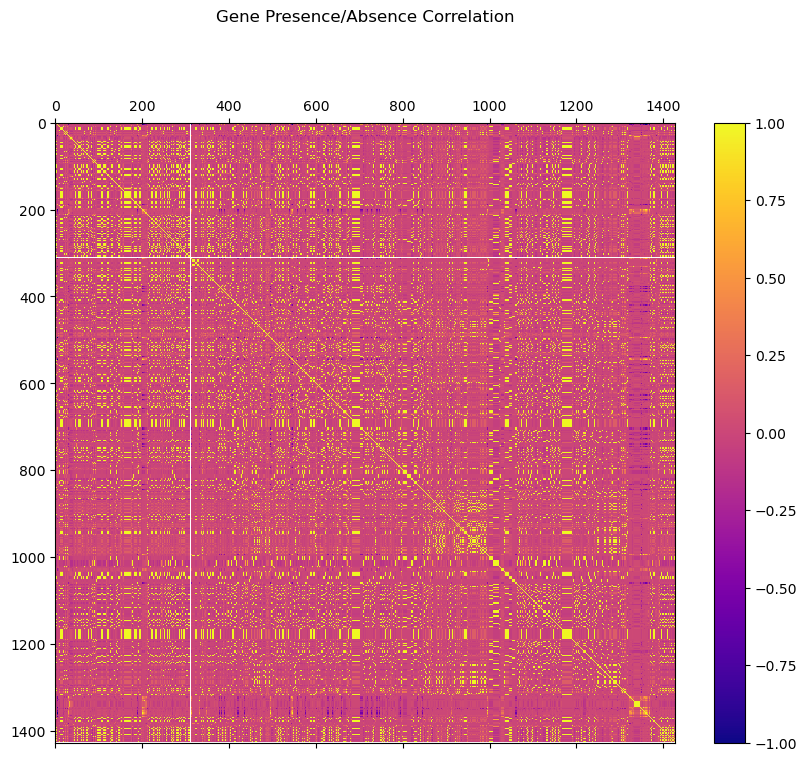

In [16]:
### Add your code here
correlation_matrix = gene_presence_absence.corr()

plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, fignum=1, cmap='plasma')
plt.title('Gene Presence/Absence Correlation', y=1.15)

plt.colorbar()
plt.show()


## 2. Feature to Target Correlations

We've just seen that there are a lot of correlations between features and a lot of redundancy where genes appear to be similar to one another.

What about how these genes relate to our target however?

#### Q2a. How many S/R phenotypes do we have?

Use the `amr_df` and the `target` columns

In [7]:
### Add your code here
pheno = amr_df['target'].value_counts()
print(pheno)

target
S    598
R    151
Name: count, dtype: int64


#### Q2b. Which Gene appears most frequently in R samples? (There are a few ties, select any)

Use `amr_df` and `gene_presence_absence`

In [17]:
# Get the genome IDs for just target=R samples
R_genome_ids = amr_df[amr_df.target == 'R'].genome_id

# Subset presence absence genes to just R_genome_ids (hint: pandas.loc[] is useful here)
R_genome_gene_pa = gene_presence_absence.loc[R_genome_ids]

# Sum across rows (genomes)
gene_presence_counts = R_genome_gene_pa.sum(0)

# Sort and view the top 5 most occuring genes
frequent = gene_presence_counts.sort_values(ascending=False).head(5)
print(frequent)

res_gene
gb|NG_049081.1|+|100-1234|ARO:3006876|EC-15                151.0
gb|U00096.3|-|2336792-2339420|ARO:3003294|Ecol_gyrA_FLO    151.0
gb|AP009048.1|-|4306556-4307588|ARO:3003548|mdtN           151.0
gb|AP009048.1|-|4304505-4306557|ARO:3003549|mdtO           151.0
gb|AP009048.1|-|4303042-4304509|ARO:3003550|mdtP           151.0
dtype: float64


In [9]:
# The code below will repeat this for S samples for your top gene
most_occuring_res_gene = 'gb|NG_049081.1|+|100-1234|ARO:3006876|EC-15' # Fill this in with the string for most occuring gene

S_genome_ids = amr_df[amr_df.target == 'S'].genome_id
S_genome_gene_pa = gene_presence_absence.loc[S_genome_ids]
gene_count_in_S_samples = sum(S_genome_gene_pa.loc[:, most_occuring_res_gene])

print(f'{most_occuring_res_gene} appears in S samples: {gene_count_in_S_samples} times')

gb|NG_049081.1|+|100-1234|ARO:3006876|EC-15 appears in S samples: 589.0 times


#### Q2c. What do you notice about how the presence/absence counts relate to the total S/R counts?

The most frequently occurring genes in the resistant samples also occurs in nearly all susceptible samples

#### Q2d. Lets Visualize this across a sample of Random Genes

I've provided a function you can use to grab the counts of S/R for a few random genes

In [10]:
# Grab some random genes
def count_rs_for_random_genes(n=10, random_state=13):
    random_genes = gene_alignment_df.res_gene.sample(n, random_state=random_state)
    
    # Count 
    genes_with_amr = pd.merge(
        gene_alignment_df, 
        amr_df, 
        how='left', 
        on='genome_id',
    )
    count_rs_genes = genes_with_amr.value_counts(['res_gene', 'target'])
    random_genes_count_rs = count_rs_genes.loc[random_genes].to_frame('count').reset_index()
    return random_genes_count_rs

count_rs = count_rs_for_random_genes()

In [11]:
# Take a look at the count_rs data
print(count_rs)

                                             res_gene target  count
0        gb|HM246246.1|+|211-1069|ARO:3001047|TEM-187      S    303
1        gb|HM246246.1|+|211-1069|ARO:3001047|TEM-187      R     58
2          gb|NG_065939.1|+|0-861|ARO:3005272|TEM-242      S    303
3          gb|NG_065939.1|+|0-861|ARO:3005272|TEM-242      R     58
4        gb|U00096.3|-|481253-484403|ARO:3000216|acrB      S    597
5        gb|U00096.3|-|481253-484403|ARO:3000216|acrB      R    151
6    gb|AP009048.1|-|4338624-4340268|ARO:3003576|eptA      S    589
7    gb|AP009048.1|-|4338624-4340268|ARO:3003576|eptA      R    149
8           gb|KF663615.1|+|0-858|ARO:3001390|TEM-213      S    303
9           gb|KF663615.1|+|0-858|ARO:3001390|TEM-213      R     58
10        gb|AY874537.1|+|177-1038|ARO:3000883|TEM-11      S    303
11        gb|AY874537.1|+|177-1038|ARO:3000883|TEM-11      R     58
12  gb|U00096.3|-|985893-986982|ARO:3003390|Ecol_o...      S    593
13  gb|U00096.3|-|985893-986982|ARO:3003390|Ecol

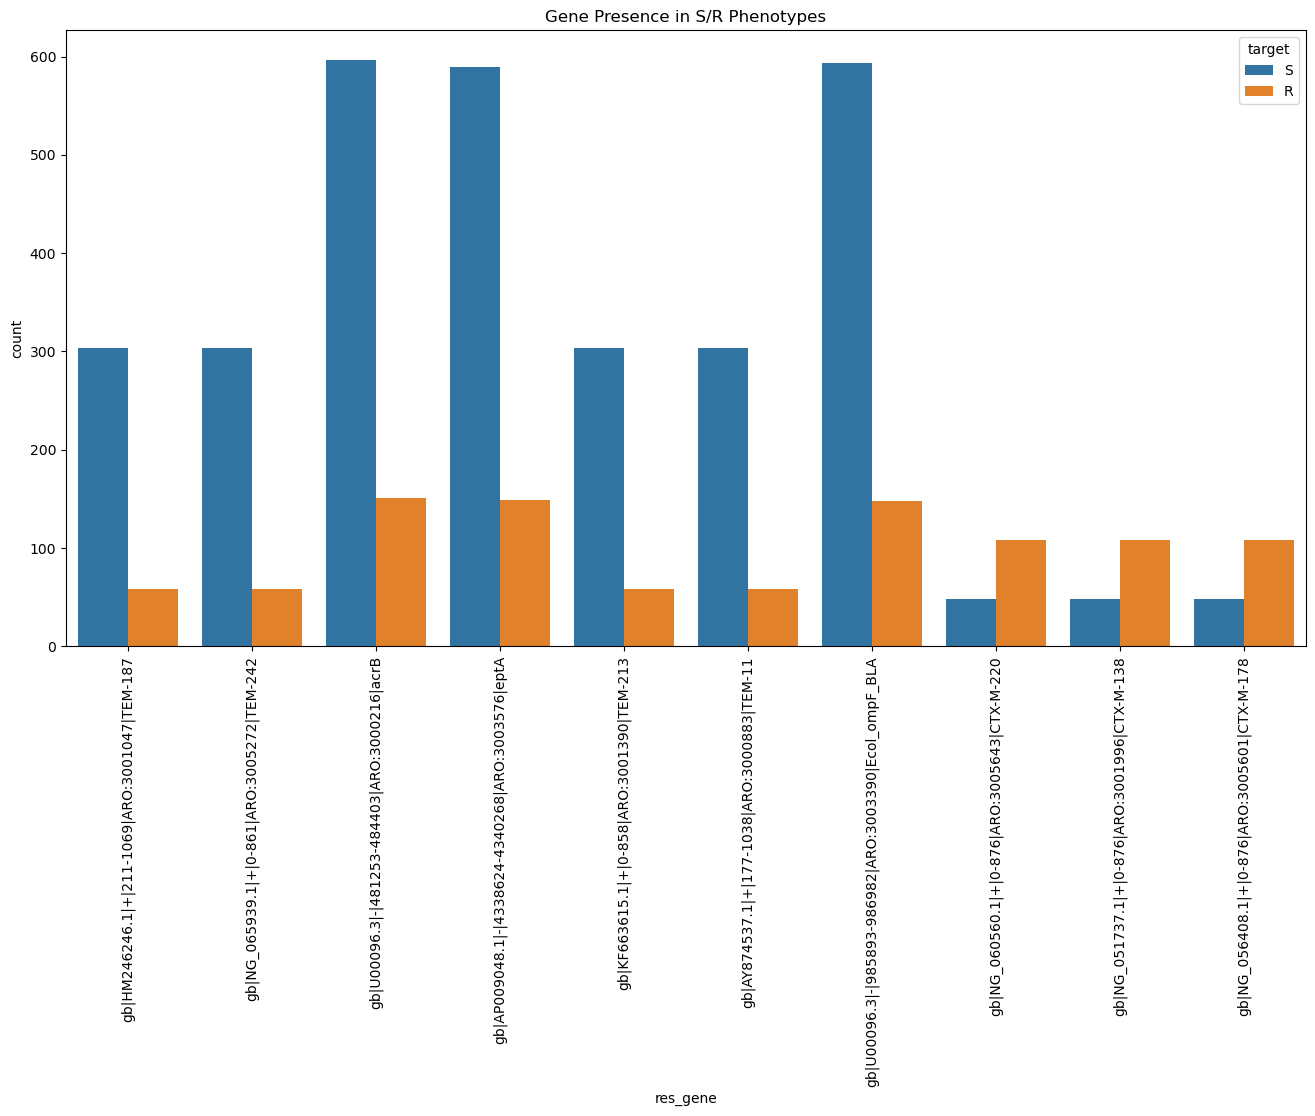

In [12]:
# Build a Barplot (using Seaborn)
# With: res_gene on the X axis, count on the y axis and the hue (color) being the target
fig, ax = plt.subplots(1,1, figsize=(16,8))
sns.barplot(
   x = count_rs['res_gene'],
   y = count_rs['count'],
   hue = count_rs['target']
)
ax.set_title('Gene Presence in S/R Phenotypes')

# The code below rotates the x axis labels to make it easier to read
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()